In [2]:
import os, sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
bigdama_path = "/home/andres/CAiN_repos/OutlierDenStream-BigDama18/"
sys.path.append(bigdama_path)

from readGroundTruth import groundTruth

In [4]:
def normalize_matrix(df):
    return (df - df.mean())/df.std()

configuration = json.load(open('configuration.json'))
print(configuration['featureModel'])

# Iterate on all the datasets chosen in the configuration list
for dataset in configuration['dataset']['list']:
    
    # read the ground truth file
    truth = groundTruth(bigdama_path + 'GrounTruth/'+dataset+'.txt', fileType='csv')
    
    # Iterate on all the nodes chosen in the configuration file
    for node in configuration['nodes']:

        # Read node dataset
        print('Dataset {} - Node: {} loading ...'.format(dataset,node))
        df = pd.read_csv(bigdama_path+configuration['dataset']['path']+node+dataset+'.csv', low_memory = False)\
                        .dropna()\
                        .drop('Unnamed: 0', axis=1)
        print('Done.')
        
        times = pd.DataFrame(columns=['time'])
        times['time'] = df['time'].astype('int')
        df = df.drop(['time'], axis=1)

        # Select the chosen features in the configuration file
        # By default the dataset contains all the features
        # If ControlPlane is chosen: only the CP features are extracted from the dataset
        # If DataPlane is chosen: the CP features are discarded, obtaining a dataset with only DataPlane
        # If CompleteFeatures is chosen: pass
        if configuration['featureModel'] == 'ControlPlane':
            features = 'CP'
            df = df[configuration['featureList']]
        elif configuration['featureModel'] == 'DataPlane':
            features = 'DP'
            df = df.drop(configuration['featureList'], axis=1)
        elif configuration['featureModel'] == 'CompleteFeatures':
            features = 'All'
        else:
            sys.exit('Something wrong in configuration feature model')

        # Dataset normalization
        df_short = df.loc[:,df.std()!=0]
        dfNormalized = normalize_matrix(df_short).dropna(axis=1)
        del df_short
        
        #dfNormalized[0:].to_csv('bgpclear_first_leaf1_DP.emb', index=False, header=False, na_rep=0, sep='\t')
        df[0:].to_csv(dataset+'_'+node+'_'+features+'.emb', index=False, header=False, na_rep=0, sep='\t')
        
        # Create anomaly data
        times['anomaly'] = 0 # add new column

        # flag entries within anomaly ranges
        for anomaly in truth.events:
            mask = times['time'].between(anomaly['startTime'], anomaly['endTime'])
            times['anomaly'] = times['anomaly'].mask(mask, 1)

        times[0:].to_csv(dataset+'_'+node+'_'+features+'.lbl', index=False, header=True, na_rep=0, sep='\t')
        
df.head()

DataPlane
Dataset bgpclear_first - Node: leaf1 loading ...
Done.


,0/RP0/CPU0acl-in-rpf-packets,0/RP0/CPU0checksum-error-packets,0/RP0/CPU0df-unreachable-packets,0/RP0/CPU0discard-packets,0/RP0/CPU0encapsulation-failure-packets,0/RP0/CPU0fragmenation-consumed-packets,0/RP0/CPU0fragmenation-failure-packets,0/RP0/CPU0gre-error-drop,0/RP0/CPU0gre-lookup-failed-drop,0/RP0/CPU0incomplete-adjacency-packets,...,HundredGigE0/0/0/9input-drops,HundredGigE0/0/0/9input-errors,HundredGigE0/0/0/9input-ignored-packets,HundredGigE0/0/0/9input-queue-drops,HundredGigE0/0/0/9output-buffer-failures,HundredGigE0/0/0/9output-drops,HundredGigE0/0/0/9output-errors,HundredGigE0/0/0/9output-queue-drops,HundredGigE0/0/0/9packets-received,HundredGigE0/0/0/9packets-sent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.023780e+12,1.051613e+12
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.023782e+12,1.051616e+12
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.023787e+12,1.051620e+12
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.023792e+12,1.051623e+12
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.023797e+12,1.051627e+12


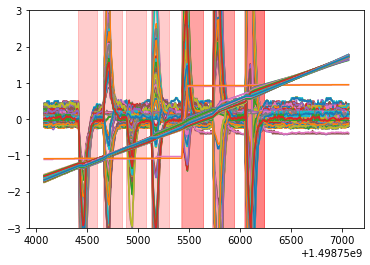

In [63]:
fig, ax = plt.subplots()
#ax.plot(times, dfNormalized['active-routes-count'], 'b')
#ax.plot(times, dfNormalized['deleted-routes-count'], 'g')
#ax.plot(times, dfNormalized['paths-count'], 'r')
#ax.plot(times, dfNormalized['protocol-route-memory'], 'y')
ax.plot(times, dfNormalized)
#ax.axis([0, 700, 900, 1500])
ax.set_ylim([-3, 3])
for anomaly in truth.events:
    ax.axvspan(anomaly['startTime'], anomaly['endTime'], alpha=0.2, color='red')